# Data-Oriented Programming Paradigms: Exercise 3

This jupyter notebook should be used for merging the different datasets we have.   
Every person has their own cell where they can prepare their data so it matches the structure we agreed on.  
[Format Picture](pandasformat.png) - The two indexes should be named **year** and **country_name**

##### Take Note: (Add additional points to the list if needed)

* Put your data files into the data/ directory (make sure your files have reasonable size)
* Try to name your data variable appropriately (e.g. use initials)
* When you commit your changes try to reduce unnecessary jupyter notebook output to a minimum so it is easier for everyone to read the commits on Github

## General Imports

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import missingno as msno

## Data preparation (done individually)

The data is collected from different sources. Each group member collected relevant data. The outcome of the collection is 4 csv files. The data mainly includes information about the health, the bank information and the status of the country. <br>
The data is loaded from each file. Attributes are selected according to relevance. The attributes "year" and "country_name" are present in all datasets. The names of these attributes are changed and set as index all datasets to facilitate data merging.  

In [2]:
## Bogensperger Johannes
data_wb = pd.read_csv('data/Data_Dump_Worldbank_301219_V2/data_worldbank.csv', delimiter=',', header=0,
                      usecols=['year', 'country_name',  # 'Country_code',
                               'GDP per capita',
                               'life expectancy at birth',
                               'physicians (per 1,000)',
                               'hospital beds (per 1,000)',
                               'nurses and midwives (per 1,000)',
                               'urban population (% of total pop)',
                               'government health expenditure (% of GDP)',
                               'government health expenditure per capita, PPP ',
                               'private health expenditure (% total health exp)',
                               'GDP (current US$)',
                               'GDP per capita, PPP (current international $)',
                               'coverage of social insurance (%)',
                               'coverage of social protection and labor programs (%)'],
                      names=['year', 'time_code', 'country_name', 'country_code',
                             'GDP per capita',
                             'life expectancy at birth',
                             'physicians (per 1,000)',
                             'hospital beds (per 1,000)',
                             'nurses and midwives (per 1,000)',
                             'urban population (% of total pop)',
                             'government health expenditure (% of GDP)',
                             'government health expenditure per capita, PPP ',
                             'private health expenditure (% total health exp)',
                             'GDP (current US$)',
                             'GDP per capita, PPP (current international $)',
                             'coverage of social insurance (%)',
                             'coverage of social protection and labor programs (%)']
                      )

data_health = pd.read_csv('data/Data_Dump_Health_Stats_301219_V2/data_health_wb.csv', delimiter=',', header=0,
                          usecols=['year', 'country_name',  # 'Country Code',
                                   'smoking prevalence, total',
                                   'alcohol consumption per capita (liters)',
                                   'people with drinkwater (%)',
                                   'people with basic handwashing (%)',
                                   'school enrollment, primary',
                                   'school enrollment, secondary',
                                   'school enrollment, tertiary'],
                          names=['year', 'Year Code', 'country_name', 'Country Code',
                                 'smoking prevalence, total',
                                 'alcohol consumption per capita (liters)',
                                 'people with drinkwater (%)',
                                 'people with basic handwashing (%)',
                                 'school enrollment, primary',
                                 'school enrollment, secondary',
                                 'school enrollment, tertiary'])

data_wb = data_wb.dropna(how='any')#Drop those last NA lines in the file..
data_wb['year'] = data_wb['year'].astype(dtype='int64')
data_wb.set_index(['year', 'country_name'], drop=True, append=False, inplace=True)
data_wb.replace("..", np.NaN, inplace=True)
data_wb = data_wb.astype(dtype=float)

data_health = data_health.dropna(how='any')#Drop those last NA lines in the file..
data_health['year'] = data_health['year'].astype(dtype='int64')#
data_health.set_index(['year', 'country_name'], drop=True, append=False, inplace=True)
data_health.replace("..", np.NaN, inplace=True)
data_health = data_health.astype(dtype=float)

In [3]:
## Stephan Siegl
data_ss = pd.read_csv("data/characteristics_siegl.csv")
data_ss.rename(columns={"time" : "year", }, inplace=True)
# drop not needed columns
data_ss.drop(['time_code', 'country_code'], axis=1, inplace=True)

data_ss.set_index(["year", "country_name"], inplace=True)
data_ss.sort_values(["year", "country_name"], ascending=True, inplace=True)
# set .. values to NaN
data_ss.replace("..", np.NaN, inplace=True)
# change to numeric values
data_ss = data_ss.apply(pd.to_numeric)
#data_ss.dtypes
#fig = plt.figure(figsize=(9, 7))
#plt.xticks(range(data_ss.shape[1]), data_ss.columns, fontsize=11)
#plt.xticks(rotation=90)
#plt.yticks(range(data_ss.shape[1]), data_ss, fontsize=11)
#plt.title('Correlation Matrix', fontsize=16)
#sns.heatmap(data_ss.corr())
#plt.plot()

In [4]:
## Maroua Jaoua
data_who = pd.read_csv('data/who_data.csv', delimiter=',', header=0,                       
                       usecols=['Country', 'Year', 
                                'Status', 'Adult Mortality', 'infant deaths', 
                                'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 
                                'Polio', 'Diphtheria ', ' HIV/AIDS',
                                ' thinness  1-19 years', ' thinness 5-9 years'])
data_who.columns =['country_name', 'year',
                   'Status', 'Adult Mortality', 'infant deaths',
                   'Hepatitis B', 'Measles', 'BMI', 'under-five deaths',
                   'Polio', 'Diphtheria', ' HIV/AIDS',
                   'thinness  1-19 years', 'thinness 5-9 years']
data_who['year'] = data_who['year'].astype(dtype='int64')
data_who.set_index(['year', 'country_name'], drop=True, append=False, inplace=True)
data_who.sort_index(inplace=True)
data_who = data_who.loc[:, data_who.columns != 'Status'].astype(dtype=float)
#data_who

## Merging DATA

After loading the data and setting a common index between all the dataframes, the latters are merged. A full outer join is performed. Furthemore, the number of columns and rows of the data are shown. The merged dataset includes 46 attributes and 15959. 

In [5]:
# merge data according to multiindex year and country_name
OUTPUTPATH = 'data/preprocessedData.csv'

#TODO check if sizes get bigger --> indicator index is broken.. (keep attention to have index year=int64, country_name=object 
merged_data = data_health.merge(right=data_wb, how='outer', left_index=True, right_index=True)
merged_data = merged_data.merge(right=data_ss, how='outer',  left_index=True, right_index=True)
merged_data = merged_data.merge(right=data_who, how='outer',  left_index=True, right_index=True)

print('Shape WB Data:' + str(data_wb.shape))
print('Shape Health Data:' + str(data_health.shape))
print('Shape SS Data:' + str(data_ss.shape))
print('Shape WHO Data:' + str(data_who.shape))
#ADDD 

print('Shape final merged Data:' + str(merged_data.shape))

merged_data.to_csv(OUTPUTPATH, header=True, index=True, encoding='')


Shape WB Data:(13020, 13)
Shape Health Data:(15540, 7)
Shape SS Data:(4340, 15)
Shape WHO Data:(2938, 11)
Shape final merged Data:(15959, 46)


## Data Cleaning

Since an outer join is performed, missing values are generated. First of all, the years with a very high number of missing values are investigated and dropped if they exceed a certain percentage. In the following it can be seen that it would make sense to leave the data from the years 2000 to 2016 since the percentage of missing data for these years are reasonable. It can be seen that for the years 1960 to 1999 and 2017 to 2019, the percentage of missing values is higher than 85%. Assumptions on the missing values can be done and algorithms for missing values can be used.

In [61]:
def percentage_missing_year(merged_data):
    not_missing = merged_data.count(level="year").sum(axis=1)
    total = merged_data.groupby(level='year').size() * merged_data.shape[1]
    percentage = (total - not_missing) / total
    return percentage.to_frame().rename(columns={0: "Percentage"})
percentage_missing_year(merged_data).head()

,Percentage
year,
1960,0.927145
1961,0.947960
1962,0.947960
1963,0.948044
1964,0.948044


The data is trimmed and only the data for the years between 2000 and 2016 are kept.

In [7]:
data_trimmed = merged_data.loc[range(2000, 2017)]
data_trimmed

smoking prevalence, total  \
year country_name                                    
2000 Afghanistan                               NaN   
     Albania                             34.800000   
     Algeria                             16.600000   
     American Samoa                            NaN   
     Andorra                             37.400000   
...                                            ...   
2016 West Bank and Gaza                        NaN   
     World                               20.485784   
     Yemen, Rep.                         18.400000   
     Zambia                              13.800000   
     Zimbabwe                            15.800000   

                         alcohol consumption per capita (liters)  \
year country_name                                                  
2000 Afghanistan                                             NaN   
     Albania                                                 NaN   
     Algeria                                                 NaN   
     American Samoa                                          NaN   
     Andorra                                                 NaN   
...                                                          ...   
2016 West Bank and Gaza                                      NaN   
     World                                              6.379662   
     Yemen, Rep.                                        0.100000   
     Zambia                                             4.800000   
     Zimbabwe                                           4.800000   

                         people with drinkwater (%)  \
year country_name                                     
2000 Afghanistan                          27.771897   
     Albania                              87.866618   
     Algeria                              89.837259   
     American Samoa                       98.459089   
     Andorra                             100.000000   
...                                             ...   
2016 West Bank and Gaza                   96.475668   
     World                                89.194711   
     Yemen, Rep.                          63.322034   
     Zambia                               59.238564   
     Zimbabwe                             64.511616   

                         people with basic handwashing (%)  \
year country_name                                            
2000 Afghanistan                                       NaN   
     Albania                                           NaN   
     Algeria                                           NaN   
     American Samoa                                    NaN   
     Andorra                                           NaN   
...                                                    ...   
2016 West Bank and Gaza                                NaN   
     World                                             NaN   
     Yemen, Rep.                                 49.335099   
     Zambia                                      13.828135   
     Zimbabwe                                    36.801495   

                         school enrollment, primary  \
year country_name                                     
2000 Afghanistan                           20.95758   
     Albania                              104.19619   
     Algeria                              105.16491   
     American Samoa                             NaN   
     Andorra                                    NaN   
...                                             ...   
2016 West Bank and Gaza                    97.45101   
     World                                103.95040   
     Yemen, Rep.                           93.63748   
     Zambia                                98.60698   
     Zimbabwe                                   NaN   

                         school enrollment, secondary  \
year country_name                                       
2000 Afghanistan                                  NaN   
     Albania               

Furthemore, a closer look into the country names should also be done. This step is done after dropping the years with very high missing values percentage to avoid unecessary data handling. This is because the names of the countries might change over the years. It is also common to have names of countries which are problematic because they have special characters. There are also some abbriviations and typos which should also be considered. <br>
To investigate all of these concerns, a list of the countries is imported from the package pycoutries. The name of the countries which are contained in the merged dataset and not contained in the correct list of countries are investigated <br>
In the following, one can see that there are many changes that should be performed. For example, "Arab World", "Europe & Central Asia" and "East Asia & Pacific" should be deleted since they are rather regions and not countries. <br>
"Iran, Islamic Rep." and "Iran (Islamic Republic of)" are the same country. However, they are named differently. They are both changed to "Iran, Islamic Republic of". There are many other countries which have this same problem. <br>
"Cote d'Ivoire" which is in french is missing a special character and is changed to "Côte d'Ivoire". Many other changes are also performed. <br>
The former Yugoslav republic of Macedonia is also in the dataset and should be handled.

The list obtained from the pycountry package includes 249 countries, territories, or areas of geographical interest according to the official codes in ISO 3166-1. 

In [59]:
# get the list of all countries in the world
countries_list = [x.name for x in pycountry.countries]
    
def unify_names(data_corrected, key, value):
    data_corrected.country_name = np.where(data_corrected.country_name==key, 
                                           value, data_corrected.country_name)
def correct_countries_names(data_trimmed):
    # find the indices that are not countries of the world
    np.setdiff1d(data_trimmed.index.get_level_values(1), countries_list)

    # delete irrelevant rows with irrelevant indices
    countries_to_delete = ['Arab World', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)',
                          'East Asia & Pacific (excluding high income)', 'Central Europe and the Baltics',
                          'Euro area', 'Europe & Central Asia','Europe & Central Asia (IDA & IBRD countries)',
                           'Europe & Central Asia (excluding high income)', 'European Union',
                           'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 
                           'High income', 'Latin America & Caribbean',
                           'Latin America & Caribbean (excluding high income)',
                           'Latin America & the Caribbean (IDA & IBRD countries)',
                           'Least developed countries: UN classification',
                           'Low & middle income', 'Low income', 'Lower middle income', 
                           'Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD countries)',
                           'Middle East & North Africa (excluding high income)',
                           'Middle income', 'Sub-Saharan Africa (IDA & IBRD countries)',
                           'Sub-Saharan Africa (excluding high income)', 'Upper middle income',
                          'OECD members', 'Other small states', 'Early-demographic dividend', 
                           'North America','Sub-Saharan Africa', 'Small states',
                           'South Asia', 'South Asia (IDA & IBRD)', 'Post-demographic dividend',
                           'Pre-demographic dividend','Not classified', 'Pacific island small states',
                          'World', 'Late-demographic dividend', 'Caribbean small states',
                            'United Kingdom of Great Britain and Northern Ireland', 'Channel Islands' ]
    data_corrected = data_trimmed.drop(countries_to_delete, level=1)
    
    # correct country names. But, first reset the index.
    # This is because if you have two countries with the same name and then correct the index,
    # Then, you would have two indices with the same value and python will throw an error.
    data_corrected.reset_index(inplace=True)
    countries_to_correct = {"Bahamas, The":"Bahamas",
                           "Bolivia":"Bolivia, Plurinational State of",
                           "Bolivia (Plurinational State of)":"Bolivia, Plurinational State of",
                           "Iran, Islamic Rep.":"Iran, Islamic Republic of",
                            "Iran (Islamic Republic of)":"Iran, Islamic Republic of",
                           'Swaziland':'Eswatini',
                           'Yemen, Rep.':'Yemen',
                            'Moldova':'Moldova, Republic of',
                            'Republic of Moldova':'Moldova, Republic of',
                            'Vietnam':'Viet Nam',
                            'Micronesia, Fed. Sts.':'Micronesia, Federated States of',
                            'Micronesia (Federated States of)':'Micronesia, Federated States of',
                            'Venezuela, RB':'Venezuela, Bolivarian Republic of',
                            'Venezuela (Bolivarian Republic of)':'Venezuela, Bolivarian Republic of',
                            'Congo, Dem. Rep.':'Congo, The Democratic Republic of the',
                            'Congo, Rep.':'Congo, The Democratic Republic of the',
                             'Democratic Republic of the Congo':'Congo, The Democratic Republic of the',
                             "Cote d'Ivoire":"Côte d'Ivoire",
                             'Czech Republic':'Czechia',
                             'Gambia, The':'Gambia',
                             'Egypt, Arab Rep.':'Egypt',
                             'British Virgin Islands':'Virgin Islands, British',
                             'Virgin Islands (U.S.)':'Virgin Islands, U.S.',
                              'Curacao':'Curaçao', 'Kyrgyz Republic':'Kyrgyzstan',
                             'Lao PDR':"Lao People's Democratic Republic",
                             'Tanzania':'Tanzania, United Republic of',
                             'United Republic of Tanzania':'Tanzania, United Republic of',
                             'Slovak Republic':'Slovakia',
                             'United States of America':'United States',
                             'West Bank and Gaza':'Palestine, State of',
                             'Macao SAR, China':'Macao',
                             'Hong Kong SAR, China':'Hong Kong',
                             "Democratic People's Republic of Korea":"Korea, Democratic People's Republic of",
                            'Korea, Dem. People’s Rep.':"Korea, Democratic People's Republic of",
                            'Korea, Rep.':'Korea, Republic of',
                            'Republic of Korea':'Korea, Republic of', 
                             'St. Kitts and Nevis':'Saint Kitts and Nevis',
                            'St. Lucia':'Saint Lucia',
                             'St. Martin (French part)':'Saint Martin (French part)',
                             'St. Vincent and the Grenadines':'Saint Vincent and the Grenadines'  
                           }
    for key, value in countries_to_correct.items():
        unify_names(data_corrected, key, value)
  
    data_corrected.set_index(['year', 'country_name'], inplace=True)
    data_corrected.sort_index(inplace=True)
    
    #print(set(data_corrected.index.get_level_values(1)))

    return data_corrected

data_corrected = correct_countries_names(data_trimmed)
data_corrected

smoking prevalence, total  \
year country_name                                         
2000 Afghanistan                                    NaN   
     Albania                                       34.8   
     Algeria                                       16.6   
     American Samoa                                 NaN   
     Andorra                                       37.4   
...                                                 ...   
2016 Virgin Islands, British                        NaN   
     Virgin Islands, U.S.                           NaN   
     Yemen                                         18.4   
     Zambia                                        13.8   
     Zimbabwe                                      15.8   

                              alcohol consumption per capita (liters)  \
year country_name                                                       
2000 Afghanistan                                                  NaN   
     Albania                                                      NaN   
     Algeria                                                      NaN   
     American Samoa                                               NaN   
     Andorra                                                      NaN   
...                                                               ...   
2016 Virgin Islands, British                                      NaN   
     Virgin Islands, U.S.                                         NaN   
     Yemen                                                        0.1   
     Zambia                                                       4.8   
     Zimbabwe                                                     4.8   

                              people with drinkwater (%)  \
year country_name                                          
2000 Afghanistan                               27.771897   
     Albania                                   87.866618   
     Algeria                                   89.837259   
     American Samoa                            98.459089   
     Andorra                                  100.000000   
...                                                  ...   
2016 Virgin Islands, British                   99.864384   
     Virgin Islands, U.S.                      98.718267   
     Yemen                                     63.322034   
     Zambia                                    59.238564   
     Zimbabwe                                  64.511616   

                              people with basic handwashing (%)  \
year country_name                                                 
2000 Afghanistan                                            NaN   
     Albania                                                NaN   
     Algeria                                                NaN   
     American Samoa                                         NaN   
     Andorra                                                NaN   
...                                                         ...   
2016 Virgin Islands, British                                NaN   
     Virgin Islands, U.S.                                   NaN   
     Yemen                                            49.335099   
     Zambia                                           13.828135   
     Zimbabwe                                         36.801495   

                              school enrollment, primary  \
year country_name                                          
2000 Afghanistan                                20.95758   
     Albania                                   104.19619   
     Algeria                                   105.16491   
     American Samoa                                  NaN   
     Andorra                                         NaN   
...                                                  ...   
2016 Virgin Islands, British                   122.23860   
     Virgin Islands, U.S.                            NaN   
     Yemen                                      93.63748   

The remaining countries which we should take care of.

In [60]:
np.setdiff1d(data_corrected.index.get_level_values(1), countries_list)

array(['Kosovo', 'The former Yugoslav republic of Macedonia'],
      dtype=object)

## Data Exploration (General)

All Features are numeric.

In [65]:
data_corrected_types = pd.DataFrame(data_corrected.dtypes, columns=["type"]).reset_index()
data_corrected_types.head()

,index,type
0,"smoking prevalence, total",float64
1,alcohol consumption per capita (liters),float64
2,people with drinkwater (%),float64
3,people with basic handwashing (%),float64
4,"school enrollment, primary",float64


The mean of the different features differ significantly. The  range of values of the features is also different from feature to feature.

In [68]:
data_corrected.describe().T.sort_values("mean").sample(5)

,count,mean,std,min,25%,50%,75%,max
smoking_prevalence_15+,1314.0,23.612329,10.795187,2.000000,15.50000,23.30000,30.400000,73.400000
people with basic handwashing (%),828.0,44.021005,33.270032,0.858730,11.81682,37.89103,79.526584,99.384718
"government health expenditure per capita, PPP",3168.0,677.811658,997.039683,0.261587,54.11455,249.09925,797.884207,8077.925836
unemployment_female_ilo_estimate,3162.0,9.521505,7.449218,0.195000,4.00725,7.31150,12.869250,44.659000
"school enrollment, primary",2781.0,102.791163,14.317184,20.882910,98.30577,102.84170,109.551740,160.996400


Range of the whole data space confirms the different ranges between all the features. 

In [79]:
data_corrected.loc[:, data_corrected.columns != "life expectancy at birth"].describe().T.describe()[["min", "max", "mean"]]

,min,max,mean
count,4.500000e+01,4.500000e+01,4.500000e+01
mean,2.932743e+05,4.157172e+11,6.276994e+09
std,1.967222e+06,2.788703e+12,4.210714e+10
min,0.000000e+00,4.428590e+00,9.250748e-01
25%,1.000000e-01,4.465900e+01,8.236955e+00
50%,5.196277e-01,9.900000e+01,3.822670e+01
75%,3.500000e+00,1.315409e+02,8.226593e+01
max,1.319654e+07,1.870719e+13,2.824633e+11


### Missing Values

The missing values are investigated by column, by country and by year.

In [70]:
def percentage_missing_columns(df):
    num = len(df.index)
    for column in df.columns:
        per = df[column].isnull().sum()/num * 100
        print(column + "\t" + str(round(per, 2)) + "% missing")
percentage_missing_columns(data_corrected)

smoking prevalence, total	67.75% missing
alcohol consumption per capita (liters)	90.82% missing
people with drinkwater (%)	11.9% missing
people with basic handwashing (%)	79.68% missing
school enrollment, primary	31.75% missing
school enrollment, secondary	40.32% missing
school enrollment, tertiary	48.22% missing
GDP per capita	15.24% missing
life expectancy at birth	16.88% missing
physicians (per 1,000)	58.38% missing
hospital beds (per 1,000)	59.29% missing
nurses and midwives (per 1,000)	64.32% missing
urban population (% of total pop)	10.85% missing
government health expenditure (% of GDP)	22.21% missing
government health expenditure per capita, PPP 	22.26% missing
private health expenditure (% total health exp)	22.21% missing
GDP (current US$)	15.04% missing
GDP per capita, PPP (current international $)	19.46% missing
coverage of social insurance (%)	92.86% missing
coverage of social protection and labor programs (%)	92.07% missing
access_electricity	14.65% missing
access_electric

In [ ]:
### Code from Stephan

Coverage of social insurance, alcohol consumption per capita and coverage of social protection and laber programs seem to have the lowest percentage of missing values as can be seen by the bar plot.

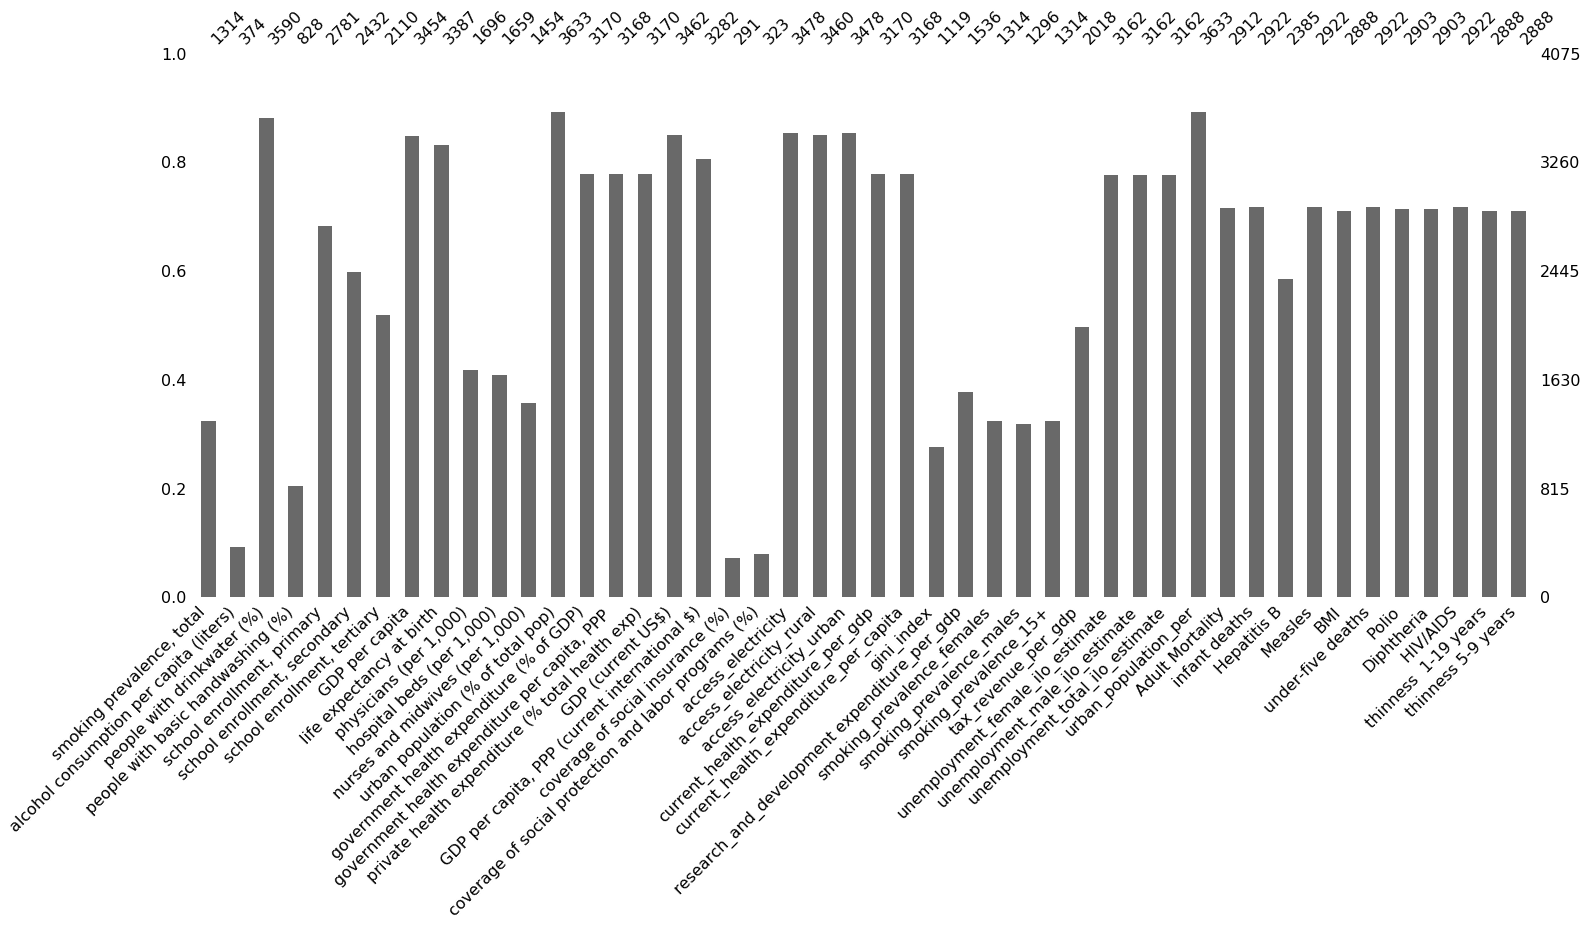

In [83]:
msno.bar(data_corrected)

From the plot below, it can be seen that the missing values have patterns. It seems that there are countries with a very high percentage of missing values while others have less missing values.

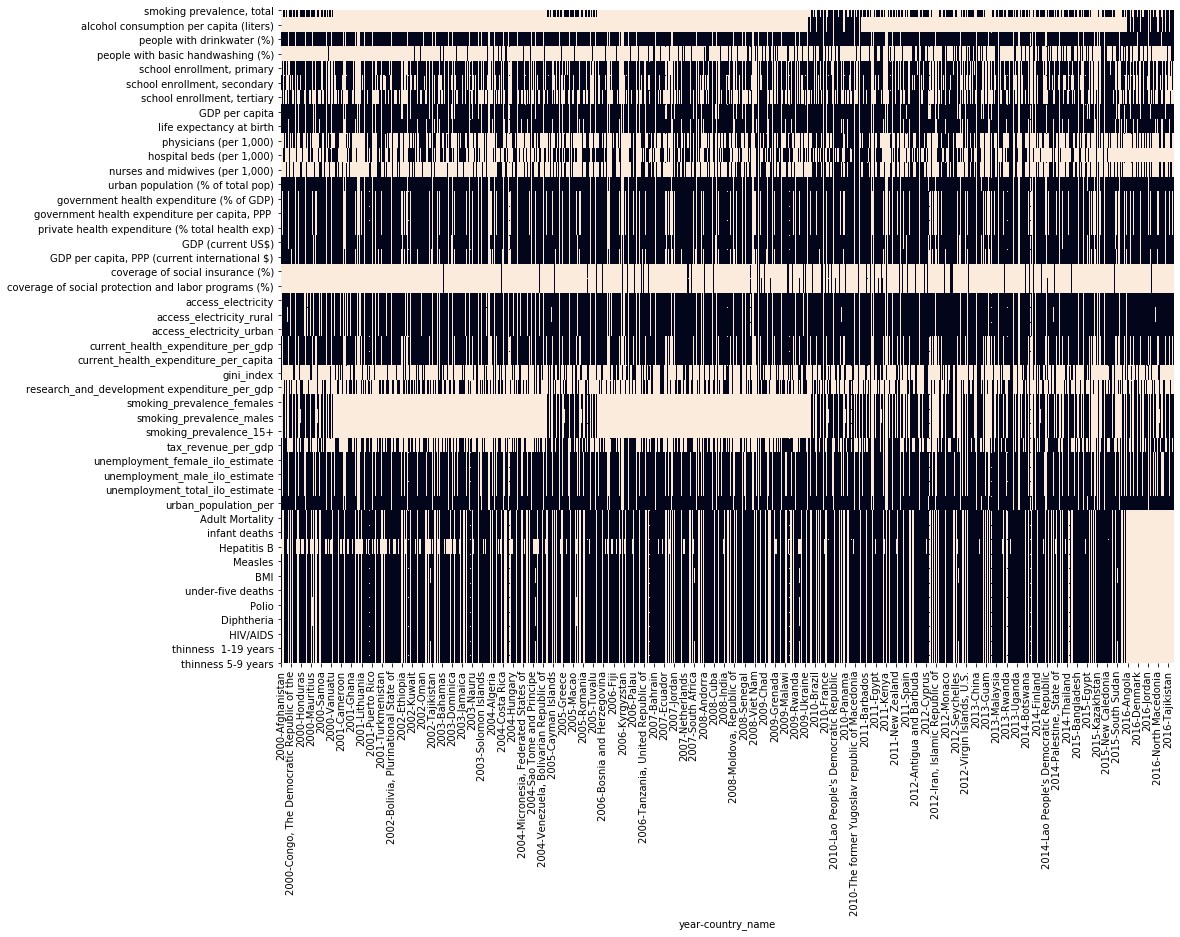

In [80]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(data_corrected.T.isnull(), cbar=False);

### Outlier detection

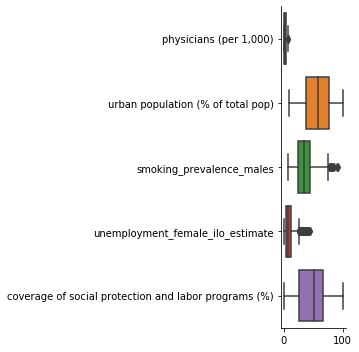

In [102]:
sns.catplot(data=data_corrected.loc[:, data_corrected.columns != "life expectancy at birth"].sample(5, axis=1, random_state = 123), 
            orient="h", kind="box")

### Data Exploration (Investigating correlation between vaccination data and life expectancy) (Maroua)

In [101]:
"""variables_of_interest = ['thinness 5-9 years']
sns.pairplot(data_corrected, vars=variables_of_interest, 
             hue="life expectancy at birth", palette="BrBG")"""

'variables_of_interest = [\'thinness 5-9 years\']\nsns.pairplot(data_corrected, vars=variables_of_interest, \n             hue="life expectancy at birth", palette="BrBG")'

### Data Exploration (Investigating correlation between +++++++ and life expectancy) (Stefan)

### Data Exploration (Investigating correlation between +++++++ and life expectancy) (Johannes)

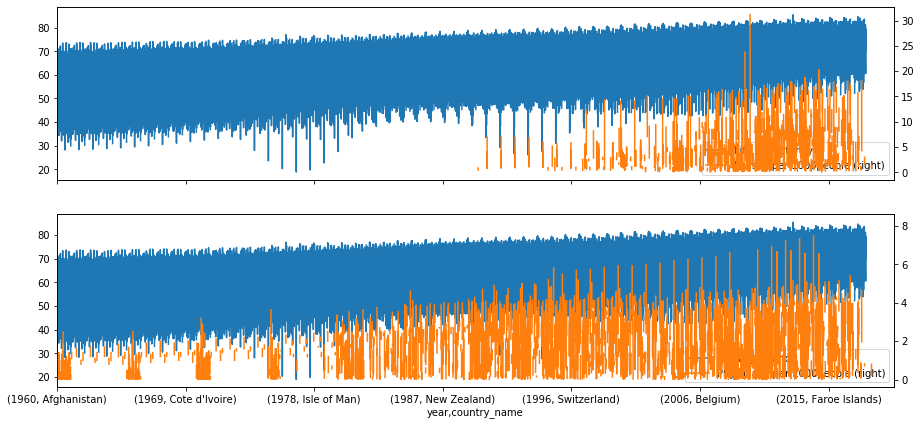

In [10]:
#Data Exploration
correlations = merged_data.corr()

#Example visualizaton, but still bullshit..
plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.xlabel('Trends of Life Expectancy with Nurses')
data_wb['life expectancy at birth'].plot(label="Life Expectancy", legend=True, )
data_wb['nurses and midwives (per 1,000)'].plot(secondary_y=True, label="Nurses per 1000people", legend=True)

plt.subplot(2, 1, 2)
plt.xlabel('rends of Life Expectancy with Physicians')
data_wb['life expectancy at birth'].plot(label="Life Expectancy", legend=True, )
data_wb['physicians (per 1,000)'].plot(secondary_y=True, label="Physicians per 1000people", legend=True)

plt.savefig('NursesAndDoctorsToLifeExpectancy.png', bbox_inches='tight')
plt.show()

## Data Preprocessing

### Handling missing values

### Handling outliers

## Prediction